In [1]:
pip install ppca

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data/customer_regime_data.csv")

features = ['Monthly_Amount','Txn_Count','Avg_Ticket','Dormancy_Days']
X = df[features].values

scaler = StandardScaler()
Xs = scaler.fit_transform(X)


In [4]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=2, random_state=42)
Z = fa.fit_transform(Xs)

Z[:5]


array([[-0.0067967 , -0.16795723],
       [-0.23405866,  0.42421441],
       [-0.2797008 , -0.04887272],
       [ 0.01393008, -0.0545236 ],
       [ 0.53777328, -0.05773593]])

In [5]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
regimes = gmm.fit_predict(Z)

df["Regime"] = regimes
df["LF1"] = Z[:,0]
df["LF2"] = Z[:,1]

C:\Users\98412\miniconda3\envs\ai_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [8]:
from ppca import PPCA
from sklearn.preprocessing import StandardScaler

ppca_models = {}
ppca_latents = {}

for r in df['Regime'].unique():
    Xr = df[df['Regime']==r][["Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"]]
    Xr = StandardScaler().fit_transform(Xr)

    ppca = PPCA()      # 2 = latent dimension
    ppca.fit(Xr,d=2)

    Z = ppca.transform(Xr)   # stable latent regime structure

    ppca_models[r] = ppca
    ppca_latents[r] = Z

In [9]:
df["LossRisk"] = (
    (df["Dormancy_Days"] > 60).astype(int) +
    (df["Avg_Ticket"] > 2200).astype(int) +
    (df["Monthly_Amount"] < 1000).astype(int)
) >= 2
df["LossRisk"] = df["LossRisk"].astype(int)


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

X = StandardScaler().fit_transform(df[["Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"]])
y = df["LossRisk"]

clf = LogisticRegression()
clf.fit(X, y)

# Primary loss-aligned latent axis
w = clf.coef_.T
df["SPCA1"] = (X @ w).flatten()

# Secondary orthogonal structural axis
X_res = X - (X @ w) @ w.T / (w.T @ w)
u, s, vt = np.linalg.svd(X_res, full_matrices=False)
df["SPCA2"] = u[:,0] * s[0]


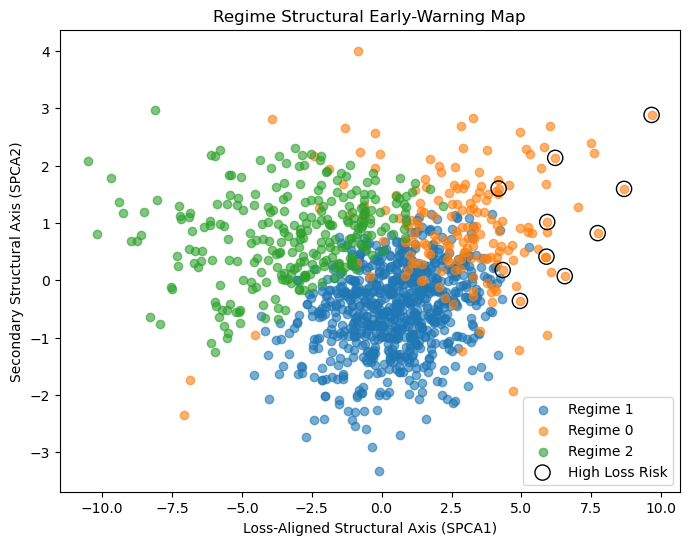

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for r in df["Regime"].unique():
    sub = df[df["Regime"]==r]
    plt.scatter(sub["SPCA1"], sub["SPCA2"], label=f"Regime {r}", alpha=0.6)

# highlight high loss risk
high = df[df["LossRisk"]==1]
plt.scatter(high["SPCA1"], high["SPCA2"], facecolors='none', edgecolors='black', s=120, label="High Loss Risk")

plt.xlabel("Loss-Aligned Structural Axis (SPCA1)")
plt.ylabel("Secondary Structural Axis (SPCA2)")
plt.title("Regime Structural Early-Warning Map")
plt.legend()
plt.show()


In [13]:
df["SII"] = np.sqrt(df["SPCA1"]**2 + df["SPCA2"]**2)

In [14]:
t1 = df["SII"].quantile(0.85)
t2 = df["SII"].quantile(0.95)

df["Structural_Status"] = np.where(df["SII"]>t2,"RED",
                          np.where(df["SII"]>t1,"AMBER","GREEN"))


In [15]:
df["Structural_Status"].value_counts()
df.groupby("Regime")["Structural_Status"].value_counts()


Regime  Structural_Status
0       GREEN                111
        AMBER                 47
        RED                   19
1       GREEN                733
        AMBER                 19
2       GREEN                176
        AMBER                 54
        RED                   41
Name: count, dtype: int64

In [17]:
df["Time"] = (
    df["Dormancy_Days"].rank(method="average") +
    (-df["Txn_Count"]).rank(method="average") +
    (-df["Monthly_Amount"]).rank(method="average")
)



In [18]:
df = df.sort_values("Time")   # if you have time; otherwise simulate index
df["dSPCA1"] = df.groupby("Regime")["SPCA1"].diff()
df["dSPCA2"] = df.groupby("Regime")["SPCA2"].diff()
df["Drift_Velocity"] = np.sqrt(df["dSPCA1"]**2 + df["dSPCA2"]**2)


In [20]:
df["Collapse_Acceleration"] = df.groupby("Regime")["Drift_Velocity"].diff()



In [21]:
v1 = df["Drift_Velocity"].quantile(0.85)
a1 = df["Collapse_Acceleration"].quantile(0.90)

df["Drift_Status"] = np.where(
    (df["Drift_Velocity"] > v1) & (df["Collapse_Acceleration"] > a1),
    "COLLAPSE_TRAJECTORY", "STABLE"
)


In [22]:
df[["Time","Drift_Velocity","Collapse_Acceleration"]].describe()


,Time,Drift_Velocity,Collapse_Acceleration
count,1200.000000,1197.000000,1194.000000
mean,1801.500000,2.053655,-0.001941
std,597.247986,1.386450,1.623580
min,114.500000,0.043844,-8.083639
25%,1388.000000,1.071447,-0.935953
50%,1796.500000,1.713194,0.027347
75%,2219.750000,2.780123,0.862810
max,3493.000000,11.544817,8.067167


In [23]:
v1 = df["Drift_Velocity"].quantile(0.85)
a1 = df["Collapse_Acceleration"].quantile(0.90)

df["Drift_Status"] = np.where(
    (df["Drift_Velocity"] > v1) & (df["Collapse_Acceleration"] > a1),
    "COLLAPSE_TRAJECTORY", "STABLE"
)


In [24]:
df["Drift_Status"].value_counts()
df.groupby("Regime")["Drift_Status"].value_counts()


Regime  Drift_Status       
0       STABLE                 158
        COLLAPSE_TRAJECTORY     19
1       STABLE                 722
        COLLAPSE_TRAJECTORY     30
2       STABLE                 240
        COLLAPSE_TRAJECTORY     31
Name: count, dtype: int64

In [25]:
df.groupby("Regime")["Drift_Status"].value_counts(normalize=True)


Regime  Drift_Status       
0       STABLE                 0.892655
        COLLAPSE_TRAJECTORY    0.107345
1       STABLE                 0.960106
        COLLAPSE_TRAJECTORY    0.039894
2       STABLE                 0.885609
        COLLAPSE_TRAJECTORY    0.114391
Name: proportion, dtype: float64

In [34]:
def simulate_intervention(df, regime, d_txn=0, d_dormancy=0, d_ticket=0, d_amount=0):
    sim = df[df["Regime"]==regime].copy()

    sim["Txn_Count"] += d_txn
    sim["Dormancy_Days"] += d_dormancy
    sim["Avg_Ticket"] += d_ticket
    sim["Monthly_Amount"] += d_amount

    X_sim = scaler.transform(sim[features])

    # recompute danger geometry
    SPCA1 = (X_sim @ w).flatten()
    X_res = X_sim - (X_sim @ w) @ w.T / (w.T @ w)
    SPCA2 = np.linalg.svd(X_res, full_matrices=False)[0][:,0] * np.linalg.svd(X_res, full_matrices=False)[1][0]

    SII = np.sqrt(SPCA1**2 + SPCA2**2)

    return {
        "Mean_SII": SII.mean(),
        "95pct_SII": np.quantile(SII,0.95),
        "RED_rate": (SII > t2).mean()
    }

In [28]:
scaler = StandardScaler()
scaler.fit(df[features])  
simulate_intervention(df, regime=2, d_txn=+3, d_dormancy=-15)


(3.8597013269497986, 8.177832005496864)

In [29]:
features = ["Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"]


In [35]:
simulate_intervention(df, regime=2)

{'Mean_SII': 3.5970103244790494,
 '95pct_SII': 7.584435789099901,
 'RED_rate': 0.15498154981549817}

In [37]:
simulate_intervention(df, regime=2, d_txn=+3)


{'Mean_SII': 3.52647248433697,
 '95pct_SII': 7.81808363701588,
 'RED_rate': 0.15867158671586715}

In [38]:
simulate_intervention(df, regime=2, d_dormancy=-20)

{'Mean_SII': 4.444114740499959,
 '95pct_SII': 8.466851912974132,
 'RED_rate': 0.24354243542435425}

In [39]:
simulate_intervention(df, regime=2, d_ticket=-300)

{'Mean_SII': 4.317240001255695,
 '95pct_SII': 8.540100971141253,
 'RED_rate': 0.24723247232472326}

In [40]:
simulate_intervention(df, regime=2, d_amount=+500)

{'Mean_SII': 3.8642904797280275,
 '95pct_SII': 7.901102486557767,
 'RED_rate': 0.1918819188191882}